In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
################# EVALUATE SPIN-UP FOR MESOSCALE DOMAINS ######################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
WRF_DIRECTORY_SST34 = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  
WRF_DIRECTORY_SST32 = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"  
WRF_DIRECTORY_SST30 = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
WRF_DIRECTORY_SST28 = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
WRF_DIRECTORY_SST26 = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"    
WRF_DIRS = [WRF_DIRECTORY_SST26,WRF_DIRECTORY_SST28,WRF_DIRECTORY_SST30,WRF_DIRECTORY_SST32,WRF_DIRECTORY_SST34]

# Choose which domain to evaluate
domains = ['d01','d02','d03']#,'d04','d05']

# Whether or not to save figures
saveFig = 'False'

# Vertical level to get max wind speed
i_z_max = 0

# Define common start time for all simulations
startTime = np.datetime64('2000-01-01T00:00:00')

dirFig = "/pl/active/JKL_IDEAL/hurricanes/Figures/"


In [3]:
#%% Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

In [4]:
#%% Extract maximum wind speed data for each domain and hurricane combinations
# Initialize arrays that save max wind speed for each domain and hurricane
max_ws = np.zeros([len(WRF_DIRS),len(domains),300]) + np.nan # [hurricane, domain, time]
time_ws = np.zeros([len(WRF_DIRS),len(domains),300]) + np.nan

for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    for i_d in np.arange(len(domains)): # For each simulation domain
        #  Find relevant files
        entries = os.listdir(WRF_DIRS[i_h])
        ofInterest = []
        for i in np.arange(len(entries)):
            if domains[i_d] in entries[i]:
                if 'auxH' in entries[i]:
                    ofInterest = np.append(ofInterest,i)
        ofInterest = ofInterest.astype('int')
        # Extract and save data from each auxHist file
        for i_f in np.arange(len(ofInterest)):
            # Open file
            ds = xr.open_dataset(WRF_DIRS[i_h]+str(entries[ofInterest[i_f]]),decode_times=False)
            # Extract data
            u_temp = np.array(ds['U'])
            v_temp = np.array(ds['V'])
            time_temp = np.array(ds['Times'])
            # De-stagger variables
            u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
            v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
            uv_temp = (u_temp**2 + v_temp**2)**0.5
            # Find maximum wind speed for a given vertical level
            temp_max = np.max(uv_temp[:,i_z_max,:,:])
            # Convert time string to datetime64
            a = str(time_temp[0])
            ttime = np.datetime64(a[2:12] + str(' ')+ a[13:-1])
            # Calcualte time since initialization
            ddtt = ttime - startTime
            ddtt = ddtt.astype('timedelta64[s]')
            t_since = ddtt.astype('float') # seconds since initialization
            # Save data to arrays
            max_ws[i_h,i_d,i_f] = temp_max
            time_ws[i_h,i_d,i_f] = t_since
            # Free-up memory
            u_temp = 0.0
            v_temp = 0.0
            uv_temp = 0.0
            
            ds.close()
        print("Done with domain %s in %s simulation" % (domains[i_d],WRF_DIRS[i_h]))        
        

Done with domain d01 in /pl/active/JKL_IDEAL/hurricanes/sst_26/ simulation
Done with domain d02 in /pl/active/JKL_IDEAL/hurricanes/sst_26/ simulation
Done with domain d03 in /pl/active/JKL_IDEAL/hurricanes/sst_26/ simulation
Done with domain d01 in /pl/active/JKL_IDEAL/hurricanes/sst_28/ simulation
Done with domain d02 in /pl/active/JKL_IDEAL/hurricanes/sst_28/ simulation
Done with domain d03 in /pl/active/JKL_IDEAL/hurricanes/sst_28/ simulation
Done with domain d01 in /pl/active/JKL_IDEAL/hurricanes/sst_30/ simulation
Done with domain d02 in /pl/active/JKL_IDEAL/hurricanes/sst_30/ simulation
Done with domain d03 in /pl/active/JKL_IDEAL/hurricanes/sst_30/ simulation
Done with domain d01 in /pl/active/JKL_IDEAL/hurricanes/sst_32/ simulation
Done with domain d02 in /pl/active/JKL_IDEAL/hurricanes/sst_32/ simulation
Done with domain d03 in /pl/active/JKL_IDEAL/hurricanes/sst_32/ simulation
Done with domain d01 in /pl/active/JKL_IDEAL/hurricanes/sst_34/ simulation
Done with domain d02 in /

In [5]:
#%% Colors for each simulation
from matplotlib import colors

col_26 = 'steelblue'
col_28 = 'tab:green'
col_30 = 'goldenrod'
col_32 = 'firebrick'
col_34 = 'tab:purple'
cols = [col_26,col_28,col_30,col_32,col_34]

colors.to_rgba(cols[1])

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)

In [6]:
#%% Save original arrays
time_ws_org = np.zeros_like(time_ws) + time_ws
max_ws_org = np.zeros_like(max_ws) + max_ws

In [7]:
#%% Sort data according to ascending time
for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    for i_d in np.arange(len(domains)): # For each simulation domain
        # Load data
        ts = time_ws[i_h,i_d,:]
        ws = max_ws[i_h,i_d,:]
        # Remove NaNs
        ts = ts[np.logical_not(np.isnan(ts))]
        ws = ws[np.logical_not(np.isnan(ws))]
        # Sort data
        i_sort = np.argsort(ts)
        ts = ts[i_sort]
        ws = ws[i_sort]
        # Take care of in-between NaNs
        time_ws[i_h,i_d,:] = np.nan
        max_ws[i_h,i_d,:] = np.nan
        # Save sorted data
        time_ws[i_h,i_d,0:len(ts)] = ts
        max_ws[i_h,i_d,0:len(ws)] = ws
        ts = 0.0
        ws = 0.0


In [8]:
#%% Make sure we are not plotting corrupted data
max_ws_mod = np.zeros_like(max_ws) + max_ws

# Tolerance
tol = 0.1

for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    for i_d in np.arange(len(domains)): # For each simulation domain
        # Sort data
        for it in np.arange(1,np.shape(max_ws_mod)[2]):
            if max_ws_mod[i_h,i_d,it]<max_ws_mod[i_h,i_d,it-1]*(1-tol):
                rand = np.random.rand(1)
                rand = rand-0.5
                ampl = tol*max_ws_mod[i_h,i_d,it-1]
                max_ws_mod[i_h,i_d,it] = max_ws_mod[i_h,i_d,it-1] + ampl*rand

In [9]:
#%% Common limit for each plot
mm = np.nanmax(time_ws,axis=2)
limxx = np.min(mm)

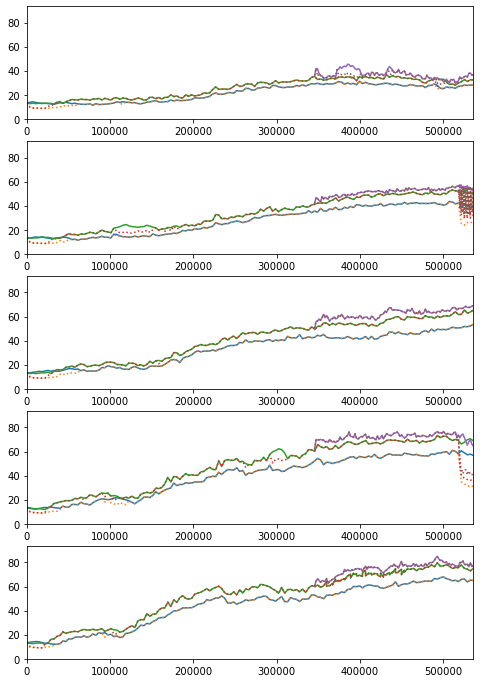

In [10]:
#%% Time series of maximum wind speed for each domain and each hurricane
# Limits for plots
limx = 1e8

mpyplot.figure(figsize=(8,12))
for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    mpyplot.subplot(len(WRF_DIRS),1,i_h+1)
    for i_d in np.arange(len(domains)): # For each simulation domain
        # Load data
        ts = time_ws[i_h,i_d,:]
        ws = max_ws_mod[i_h,i_d,:]
        # Plot data
        mpyplot.plot(ts,ws)
        mpyplot.plot(ts,max_ws[i_h,i_d,:],linestyle=':')
        if np.nanmax(ts)<limx:
            limx = np.nanmax(ts)
    mpyplot.xlim(0,limx)
    mpyplot.xlim(0,limxx)
    mpyplot.ylim(0,1.1*np.nanmax(max_ws))

mpyplot.show()

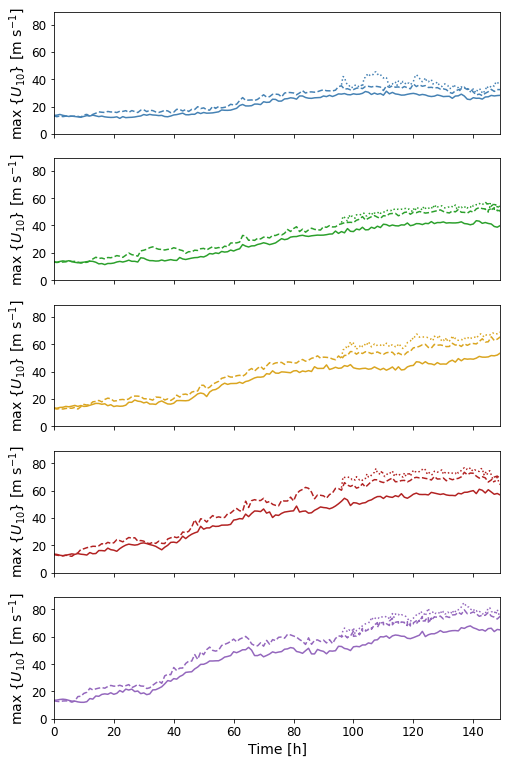

<Figure size 432x288 with 0 Axes>

In [11]:
#%% Time series of maximum wind speed for each domain and each hurricane
# Limits for plots
limx = 1e8
ls = ['-','--',':']

mpyplot.figure(figsize=(8,13))
for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    mpyplot.subplot(len(WRF_DIRS),1,i_h+1)
    for i_d in np.arange(len(domains)): # For each simulation domain
        # Load data
        ts = time_ws[i_h,i_d,:]/3600
        ws = max_ws_mod[i_h,i_d,:]
        # Plot data
        mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
        if np.nanmax(ts)<limx:
            limx = np.nanmax(ts)
    mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
    mpyplot.xlim(0,limxx/3600)
    mpyplot.ylim(0,1.1*np.nanmax(max_ws))
    mpyplot.yticks(fontsize=12)
    mpyplot.xticks(fontsize=12)
    if i_h<len(WRF_DIRS)-1:
        locs,labs = mpyplot.xticks(fontsize=12)
        mpyplot.xticks(locs,'')
    mpyplot.xlim(0,limxx/3600)
    mpyplot.ylim(0,1.05*np.nanmax(max_ws))
mpyplot.xlabel('Time [h]',fontsize=14)

mpyplot.show()

mpyplot.savefig(dirFig + "meso_spinup.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

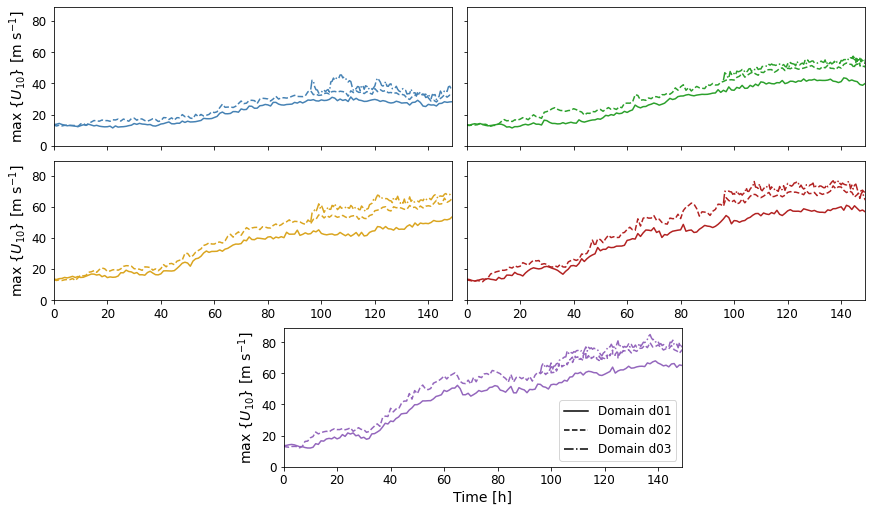

In [20]:
import matplotlib.gridspec as gridspec

fig3 = mpyplot.figure(figsize=(12,7),constrained_layout=True)
gs = fig3.add_gridspec(6, 4)

# 26 C
f3_ax1 = fig3.add_subplot(gs[0:2, 0:2])
col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
i_h = 0
for i_d in np.arange(len(domains)): # For each simulation domain
    # Load data
    ts = time_ws[i_h,i_d,:]/3600
    ws = max_ws_mod[i_h,i_d,:]
    # Plot data
    mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
    if np.nanmax(ts)<limx:
        limx = np.nanmax(ts)
mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))
mpyplot.yticks(fontsize=12)
mpyplot.xticks(fontsize=12)
locs,labs = mpyplot.xticks(fontsize=12)
mpyplot.xticks(locs,'')
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.05*np.nanmax(max_ws))
# mpyplot.xlabel('Time [h]',fontsize=14)

# 28 C
f3_ax1 = fig3.add_subplot(gs[0:2, 2:4])
col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
i_h = 1
for i_d in np.arange(len(domains)): # For each simulation domain
    # Load data
    ts = time_ws[i_h,i_d,:]/3600
    ws = max_ws_mod[i_h,i_d,:]
    # Plot data
    mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
    if np.nanmax(ts)<limx:
        limx = np.nanmax(ts)
# mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))
mpyplot.yticks(fontsize=12)
mpyplot.xticks(fontsize=12)
locs,labs = mpyplot.xticks(fontsize=12)
mpyplot.xticks(locs,'')
locs,labs = mpyplot.yticks(fontsize=12)
mpyplot.yticks(locs,'')
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.05*np.nanmax(max_ws))
# mpyplot.xlabel('Time [h]',fontsize=14)

# 30 C
f3_ax1 = fig3.add_subplot(gs[2:4, 0:2])
col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
i_h = 2
for i_d in np.arange(len(domains)): # For each simulation domain
    # Load data
    ts = time_ws[i_h,i_d,:]/3600
    ws = max_ws_mod[i_h,i_d,:]
    # Plot data
    mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
    if np.nanmax(ts)<limx:
        limx = np.nanmax(ts)
mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))
mpyplot.yticks(fontsize=12)
mpyplot.xticks(fontsize=12)
locs,labs = mpyplot.xticks(fontsize=12)
# mpyplot.xticks(locs,'')
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.05*np.nanmax(max_ws))
# mpyplot.xlabel('Time [h]',fontsize=14)

# 32 C
f3_ax1 = fig3.add_subplot(gs[2:4, 2:4])
col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
i_h = 3
for i_d in np.arange(len(domains)): # For each simulation domain
    # Load data
    ts = time_ws[i_h,i_d,:]/3600
    ws = max_ws_mod[i_h,i_d,:]
    # Plot data
    mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
    if np.nanmax(ts)<limx:
        limx = np.nanmax(ts)
# mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))
mpyplot.yticks(fontsize=12)
mpyplot.xticks(fontsize=12)
locs,labs = mpyplot.xticks(fontsize=12)
# mpyplot.xticks(locs,'')
locs,labs = mpyplot.yticks(fontsize=12)
mpyplot.yticks(locs,'')
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.05*np.nanmax(max_ws))
# mpyplot.xlabel('Time [h]',fontsize=14)

# 32 C
f3_ax1 = fig3.add_subplot(gs[4:6, 1:3])
col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
i_h = 4
for i_d in np.arange(len(domains)): # For each simulation domain
    # Load data
    ts = time_ws[i_h,i_d,:]/3600
    ws = max_ws_mod[i_h,i_d,:]
    # Plot data
    mpyplot.plot(ts,ws,color=cols[i_h],linestyle=ls[i_d])
    if np.nanmax(ts)<limx:
        limx = np.nanmax(ts)
mpyplot.ylabel(r'max {$U_{10}$} [m s$^{-1}$]',fontsize=14)
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))
mpyplot.yticks(fontsize=12)
mpyplot.xticks(fontsize=12)
locs,labs = mpyplot.xticks(fontsize=12)
# mpyplot.xticks(locs,'')
mpyplot.plot([-1,-1],[-1,-1],'k',linestyle=ls[0],label='Domain d01')
mpyplot.plot([-1,-1],[-1,-1],'k',linestyle=ls[1],label='Domain d02')
mpyplot.plot([-1,-1],[-1,-1],'k',linestyle=ls[2],label='Domain d03')
mpyplot.xlim(0,limxx/3600)
mpyplot.ylim(0,1.05*np.nanmax(max_ws))
mpyplot.xlabel('Time [h]',fontsize=14)
mpyplot.legend(fontsize=12,loc=4,ncol=1)


fig3.savefig(dirFig + "meso_spinup.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

In [13]:
np.nanmax(max_ws_mod[:,-1,:],axis=-1)

array([45.38412411, 57.41427335, 72.79808807, 76.71235657, 88.05525076])

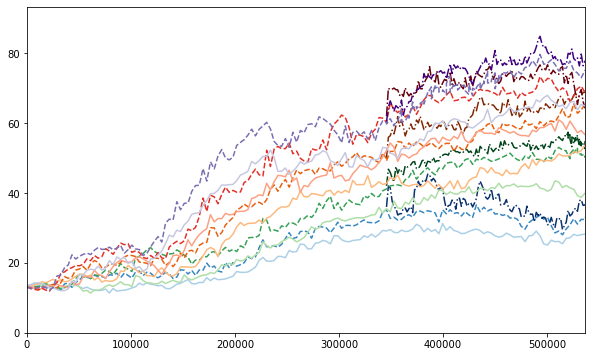

In [14]:
mpyplot.figure(figsize=(10,6))
ls = ['-','--','-.']
limx = 1e8

for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    # Choose a color
    if i_h==0:
        col = mpyplot.cm.Blues(np.linspace(0,1,len(domains)+1))
    elif i_h==1:
        col = mpyplot.cm.Greens(np.linspace(0,1,len(domains)+1))
    elif i_h==2:
        col = mpyplot.cm.Oranges(np.linspace(0,1,len(domains)+1))
    elif i_h==3:
        col = mpyplot.cm.Reds(np.linspace(0,1,len(domains)+1))
    elif i_h==4:
        col = mpyplot.cm.Purples(np.linspace(0,1,len(domains)+1))
    # Make plot
    for i_d in np.arange(len(domains)): # For each simulation domain
        # Load data
        ts = time_ws[i_h,i_d,:]
        ws = max_ws_mod[i_h,i_d,:]
        # Plot data
        mpyplot.plot(ts,ws,color=col[i_d+1],linestyle=ls[i_d])
        if np.nanmax(ts)<limx:
            limx = np.nanmax(ts)
            
mpyplot.xlim(0,limx)
mpyplot.ylim(0,1.1*np.nanmax(max_ws))

mpyplot.show()